<a href="https://colab.research.google.com/github/aritraghsh09/pop_py_prog/blob/master/ml/ml_uncertainties/robust_uncertainities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# <center>Robust Uncertainty Estimation in Machine Learning </center>
#### <center> **[Aritra Ghosh](https://ghosharitra.com)**</center>
#### <center> Ph.D. Candidate, Yale University </center>
#### <center>  </center>
#### <center> Jan./Feb. 2023 | [KITP-CCA Workshop: Data Driven Galaxy Evolution](https://datadrivengalaxyevolution.github.io/#ccaweek) </center>





<hr>

#Introduction

The title of this notebook / workshop session is too broad to be reasonably convered in the alloted time. Thus, as we go through the tutorial, we will keep narrowing our focus from uncertainties in machine learning --> uncertainties in neural networks --> Bayesian Deep Learning --> Bayesian Deep Learning for Galaxy Morphology

This Notebook is meant to be used along with the slide deck which is hosted at [this link](https://drive.google.com/file/d/1E17L5UVCiHEdOCrpSJB4U1M_05RQGFvt/view?usp=sharing) 


In [1]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
import pylab as plt
import numpy as np
import pandas as pd


try:
    import urllib
    from urllib import urlretrieve
except Exception:
    import urllib.request as urllib
from os import path
import os

#Exercise 1: Building A Classical NN to Fit Some Data


##1.1: Let's Generate Some Data

In [2]:
# Function to Create Some Data
def create_dataset():
    x = np.arange(0, 20, 0.035)
    y = x * 0.5
    y = y + np.random.normal(0, 0.5, (len(x))) * x/5
    return x, y

# Just a function to take our numpy arrays to PyTorch Tensors
def t(x):
    return torch.from_numpy(x).float()[..., None]


Text(0, 0.5, 'y')

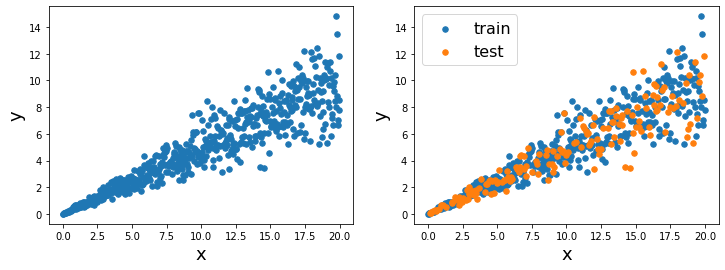

In [3]:
#Let's Generate some fake data
x, y = create_dataset()


#Let's Randomly Split This Up Into Train & Test Sets 
train_idxs = np.random.choice(len(x),size=int(0.7*len(x)),replace=False)
train_idxs = np.sort(train_idxs)

x_train = t(x[train_idxs])
x_test = t(np.delete(x,train_idxs))
y_train = t(y[train_idxs])
y_test = t(np.delete(y,train_idxs))


#Let's Plot All the Data
fig, ax = plt.subplots(1,2,figsize=(12,4))
font_size = 18

ax[0].scatter(x,y,s=30)
ax[0].set_xlabel("x",fontsize=font_size)
ax[0].set_ylabel("y",fontsize=font_size)

ax[1].scatter(x_train,y_train,s=30,label="train")
ax[1].scatter(x_test,y_test,s=30,label="test")
ax[1].legend(loc="best",fontsize=font_size-2)

ax[1].set_xlabel("x",fontsize=font_size)
ax[1].set_ylabel("y",fontsize=font_size)

##1.2: Now let's build a NN to fit this data

### 1.2.1:Pre-Written PyTorch Helper Function to Help You Train

```python
def train_model(model, loss_fn, optimizer, iterations=100, print_every=50,
                lr=0.001)

## A function to train a specified PyTorch model on the above
## dataset                

## model --> PyTorch Model
## loss_fn --> Loss Function
## optimizer --> Optimizer for Training
## iterations --> Number of Iterations to Train For
## print_every --> number of iterations after which loss value on train and 
##                 test sets are printed
## lr --> learning rate (hyper-parameter)
```

In [4]:
#@title Show Code for Above Function { vertical-output: true }
def train_model(model, loss_fn, optimizer, iterations=100, print_every=50,
                lr=0.001):
  
    optimizer.lr = lr

    for i in range(iterations):
        model.train()
        out = model(x_train)
        loss = loss_fn(y_train, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_every == 0:
            with torch.no_grad():
                model.eval()
                out = model(x_test)
                test_loss = loss_fn(y_test, out)
                print(loss, test_loss)

    return model 


###1.2.2: Define a NN with PyTorch & Train It

To help you design your own neural network for this problem, here's some PyTorch code for a neural network with 2 input neurons, 10 hidden neurons, and 3 output neurons

```python
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.LeakyReLU(0.3),
    nn.Linear(10, 3),
)
```

In the following, code block define a neural network with 1 neuron in the input layer, 20 in the hidden layer, and 1 in the output layer.

In [5]:
### Your NN code goes here


# Defining the loss function and optimizer
mse_loss = nn.MSELoss() #defining the loss as just a mean squared e
adam = optim.Adam(params=model.parameters(), lr=0.001)

NameError: ignored

In [5]:
#@title Show Answer!
model = nn.Sequential(
    nn.Linear(1, 20),
    nn.LeakyReLU(0.3),
    nn.Linear(20, 1),
)
mse_loss = nn.MSELoss()
adam = optim.Adam(params=model.parameters(), lr=0.001)

In [6]:
#Let's Train the Model Now
model = train_model(model, mse_loss, adam, iterations=4000, print_every=1000)


#Now Let's Predict on the test values
model.eval()
y_pred_test = model(x_test).detach().numpy().squeeze()

tensor(97.2280, grad_fn=<MseLossBackward0>) tensor(89.8135)
tensor(1.3788, grad_fn=<MseLossBackward0>) tensor(1.3679)
tensor(1.3481, grad_fn=<MseLossBackward0>) tensor(1.3385)
tensor(1.3469, grad_fn=<MseLossBackward0>) tensor(1.3373)


##1.3: Let's Visualize the Model Predictions on the Test Set

Text(0, 0.5, 'y')

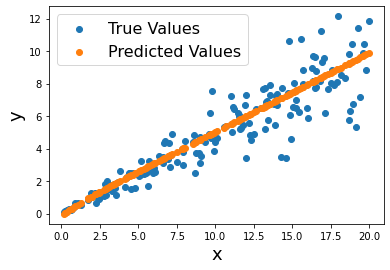

In [8]:
#Let's Now Viusalize The Predictions for the Test Set

plt.scatter(x_test,y_test,label="True Values")
plt.scatter(x_test,y_pred_test,label="Predicted Values")

font_size=18
plt.legend(loc="best",fontsize=font_size-2)
plt.xlabel("x",fontsize=font_size)
plt.ylabel("y",fontsize=font_size)

As we can see, the NN has figured out the mean relationship in the data, but completely failed to capture the amount of scatter present in our data. 


**Let's now go back to the slides to see how we might remedy this**!

# Exercise 2: Explicilty Accounting for Aleatoric Uncertainity

[GaMPEN](https://github.com/aritraghsh09/GaMPEN) is an ML framework for estimating Bayesian posteriors of morphological parameters for arbitrarily large numbers of galaxies. We will use GaMPEN later in the tutorial. 

For this problem, we will just steal the aleatoric loss function already implemented in GaMPEN for a multi-dimensional scenario. Run the cell below to install GaMEPN and check the isntallation

### Installing GaMPEN

First, let's install GaMPEN. 

Some of these commands are specifically for Google Colab. If doing this on your own machine, please follow the steps outlined [here](https://gampen.readthedocs.io/en/latest/Getting_Started.html)

In [9]:
!git clone https://github.com/aritraghsh09/GaMPEN.git

Cloning into 'GaMPEN'...
remote: Enumerating objects: 2372, done.
remote: Counting objects: 100% (720/720), done.
remote: Compressing objects: 100% (360/360), done.
remote: Total 2372 (delta 462), reused 592 (delta 355), pack-reused 1652
Receiving objects: 100% (2372/2372), 24.77 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (1550/1550), done.


In [10]:
%cd /content/GaMPEN/

!pip install -r requirements.txt 

/content/GaMPEN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/GaMPEN (from -r requirements.txt (line 2))
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/adambielski/GrouPy (to revision e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7) to /tmp/pip-install-iruz7cfn/groupy_800e2db83cf74372a03f0573a6e7e867
  Running command git clone --filter=blob:none --quiet https://github.com/adambielski/GrouPy /tmp/pip-install-iruz7cfn/groupy_800e2db83cf74372a03f0573a6e7e867
  Running command git rev-parse -q --verify 'sha^e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7'
  Running command git fetch -q https://github.com/adambielski/GrouPy e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7
  Resolved https://github.com/adambielski/GrouPy to commit e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
  Installing build depe

In order to check whether the installation has occured succesfully, run the command below.  

In [11]:
!make check

flake8 --ignore=E203,W503 ggt
pytest
============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-6.0.1, py-1.9.0, pluggy-0.13.1
rootdir: /content/GaMPEN
plugins: typeguard-2.7.1
collected 7 items                                                              

ggt/tests/test_install.py .                                              [ 14%]
ggt/tests/test_metrics.py .                                              [ 28%]
ggt/tests/test_models.py ...s                                            [ 85%]
ggt/tests/test_utils.py .                                                [100%]

======================== 6 passed, 1 skipped in 11.57s =========================


As long as the tests do not produce any errors, you are good to go! 

Note that warnings and and tests being skipped are ok! 

##2.1: Defining the New Model and Loss Function

In [12]:
from ggt.losses import AleatoricLoss  #Importing the loss from GaMPEN
                                      #Note that for a multi-dimensional
                                      #case, you would need to use 
                                      #AleatoricCovLoss instead


al_loss = AleatoricLoss(average=False) #Since we are not training in batches, 
                                       #we have set average to False

As an alternative exercise, try to implement the AleatoricLoss function
yourself! 

Here's some basic code to do it

```python

import torch.nn as nn

class AleatoricLoss(nn.Module):
    def __init__(self, average=True):
        super(AleatoricLoss, self).__init__()
        self.average = average

    def forward(self, outputs, targets):
        return aleatoric_loss(outputs, targets, average=self.average)


def aleatoric_loss(outputs, targets, average=True):
    """
    Computes the aleatoric loss.
    Args:
        outputs: (tensor) - predicted outputs from the model
        targets: (tensor) - ground truth labels
        size_average: (bool) - if True, the losses are
               averaged over all elements of the batch
    Returns:
        aleatoric_loss: (tensor) - aleatoric loss
    """

    num_out = outputs.shape[len(outputs.shape) - 1]
    if num_out % 2 != 0:
        raise ValueError(
            "The number of predicted variables should be divisible by "
            "2 for calculation of aleatoric loss"
        )

    ## FILL-IN!
    ## FILL-IN!

```

You can see the anwwer from https://github.com/aritraghsh09/GaMPEN/blob/master/ggt/losses/aleatoric_loss.py

In [ ]:
# Defining the new model 
class ModelWithError(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(1), # trick to normalize the input automatically
            nn.Linear(#?, #?), #FILL-IN THIS LINE
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(#?), #FILL-IN THIS LINE
            nn.Linear(#?, #?), #FILL-IN THIS LINE
        )
        nn.init.kaiming_normal_(self.backbone[1].weight.data)
        nn.init.ones_(self.backbone[1].bias.data)
        nn.init.kaiming_normal_(self.backbone[4].weight.data)
        nn.init.ones_(self.backbone[4].bias.data)
    
    def forward(self, X):
        out = self.backbone(X)
        
        return out


In [17]:
#@title Show Answer
# Defining the new model 

class ModelWithError(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(1), # trick to normalize the input automatically
            nn.Linear(1, 10), #FILL-IN THIS LINE
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(10), #FILL-IN THIS LINE
            nn.Linear(10, 2), #FILL-IN THIS LINE
        )
        nn.init.kaiming_normal_(self.backbone[1].weight.data)
        nn.init.ones_(self.backbone[1].bias.data)
        nn.init.kaiming_normal_(self.backbone[4].weight.data)
        nn.init.ones_(self.backbone[4].bias.data)
    
    def forward(self, X):
        out = self.backbone(X)
        
        return out

In [24]:
#@title Pre-Defined Code to Train the Model
def train_model(model, loss_fn, optimizer, iterations=100, print_every=50, 
                 lr=0.001):
    optimizer.lr = lr

    for i in range(iterations):
        model.train()
        out = model(x_train)
        loss = loss_fn(out, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_every == 0:
            with torch.no_grad():
                model.eval()
                out = model(x_test)
                test_loss = loss_fn(out,y_test)
                print(loss, test_loss)

    return model

In [25]:
# Defining the Model
model = ModelWithError()

# Defininf the Adam Optimizer
adam = optim.Adam(params=model.parameters(), lr=0.001)

# Traning the Model
model = train_model(model, al_loss, adam, iterations=20000, 
                    print_every=2000, lr=0.001)

tensor(1553.4950, grad_fn=<SumBackward0>) tensor(470.0142)
tensor(83.7121, grad_fn=<SumBackward0>) tensor(45.3139)
tensor(80.4419, grad_fn=<SumBackward0>) tensor(44.6940)
tensor(75.1616, grad_fn=<SumBackward0>) tensor(38.0682)
tensor(71.9671, grad_fn=<SumBackward0>) tensor(37.6430)
tensor(67.9449, grad_fn=<SumBackward0>) tensor(39.5877)
tensor(66.0231, grad_fn=<SumBackward0>) tensor(38.7613)
tensor(65.5783, grad_fn=<SumBackward0>) tensor(38.8852)
tensor(65.1525, grad_fn=<SumBackward0>) tensor(38.3913)
tensor(64.8928, grad_fn=<SumBackward0>) tensor(37.7232)


##2.2: Performing Predictions With the New Model

In [27]:
#Taking the Output and Reverting it to the mean and std
#for each value in the test set
#AleatoricLoss processes the two outputs as mu and 
# log(sigma^2) which we call sk below

test_out = model(x_test)
test_mean = test_out[..., 0].detach().numpy().squeeze()

test_sk = test_out[..., 1]
test_std = 0.5*torch.exp(test_sk).detach().numpy().squeeze()

Text(0, 0.5, 'y')

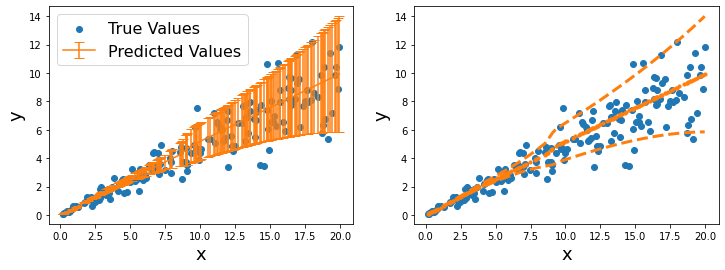

In [28]:
# Let's Plot The Predicted Means with The Errorbars as 
# 2sigma. 

fig, ax = plt.subplots(1,2,figsize=(12,4))
font_size = 18

ax[0].scatter(x_test.numpy(),y_test,label="True Values")
ax[0].errorbar(x_test.numpy(),test_mean,yerr=2*test_std,label="Predicted Values",c='C1',
               capsize=5)

ax[0].set_xlabel("x",fontsize=font_size)
ax[0].set_ylabel("y",fontsize=font_size)


ax[1].scatter(x_test.numpy(),y_test,label="True Values")
ax[1].scatter(x_test.numpy(),test_mean,label="True Values",c='C1',s=10)
ax[1].plot(x_test.numpy(), test_mean+2*test_std, linestyle="--",c='C1',lw=3)
ax[1].plot(x_test.numpy(), test_mean-2*test_std, linestyle="--",c='C1',lw=3)

ax[0].legend(loc="best",fontsize=font_size-2)

ax[1].set_xlabel("x",fontsize=font_size)
ax[1].set_ylabel("y",fontsize=font_size)

**Notes**

*  The above plot will change depending on the shape of the network that you choose to work with! Try it out! 
*  In most situations you will see that you have accounted for a lot of the scatter in the data, but not all of it! 



**This, completes the section of incorporating Aleatoric Uncertainties into our model. Now, let's look go back to the slides to look at the various options that we have for implementing Epistemic Uncertainties**

#Exercise 3: Using Monte Carlo Dropout In Our Toy Problem

Now, having learnt about epistemic uncertainties, let's try to incroporate MC Dropout in our prediction model. 

##3.1: Creating a New Model that Includes Dropout

First, we need to redefine the model that we used before to include dropout. Look up the documentation for the [PyTorch Dropout function](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and include a dropout layer in the NN below


In [ ]:
## FILL-IN THE MODEL BELOW!! 


class ModelWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(1), # trick to normalize the input automatically
            nn.Linear(#?, #?),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(#?),
            ##Dropout Layer Goes Here
            nn.Linear(#?, #?),
        )
        nn.init.kaiming_normal_(self.backbone[1].weight.data)
        nn.init.ones_(self.backbone[1].bias.data)
        nn.init.kaiming_normal_(self.backbone[5].weight.data)
        nn.init.ones_(self.backbone[5].bias.data)
    
    def forward(self, X):
        out = self.backbone(X)
        
        return out

In [31]:
#@title Show Answer
# Defining the new model 

class ModelWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(1), # trick to normalize the input automatically
            nn.Linear(1, 10),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(10),
            nn.Dropout(p=0.2),
            nn.Linear(10, 2),
        )
        nn.init.kaiming_normal_(self.backbone[1].weight.data)
        nn.init.ones_(self.backbone[1].bias.data)
        nn.init.kaiming_normal_(self.backbone[5].weight.data)
        nn.init.ones_(self.backbone[5].bias.data)
    
    def forward(self, X):
        out = self.backbone(X)
        
        return out

## 3.2: Now Train the Model! 

In [32]:
# Defining the Model
model = ModelWithDropout()

# Defininf the Adam Optimizer
adam = optim.Adam(params=model.parameters(), lr=0.001)

# Traning the Model
model = train_model(model, al_loss, adam, iterations=20000, print_every=2000, lr=0.001)

tensor(2599.8052, grad_fn=<SumBackward0>) tensor(2.6030e+11)
tensor(233.2586, grad_fn=<SumBackward0>) tensor(66.1587)
tensor(221.3417, grad_fn=<SumBackward0>) tensor(55.2692)
tensor(206.1627, grad_fn=<SumBackward0>) tensor(60.6604)
tensor(199.5480, grad_fn=<SumBackward0>) tensor(109.6169)
tensor(189.6237, grad_fn=<SumBackward0>) tensor(88.8615)
tensor(189.5173, grad_fn=<SumBackward0>) tensor(54.7244)
tensor(186.3744, grad_fn=<SumBackward0>) tensor(55.0518)
tensor(192.3467, grad_fn=<SumBackward0>) tensor(55.0793)
tensor(209.2008, grad_fn=<SumBackward0>) tensor(77.5735)


#3.3: Now Perform Inference With Dropout Enabled

In [ ]:
#Taking the Output and Reverting it to the mean and std
#for each value in the test set
#AleatoricLoss processes the two outputs as mu and 
# log(sigma^2) which we call sk below

from ggt.utils import enable_dropout
from tqdm.notebook import trange

model.eval() #Putting model in evaluation model
enable_dropout(model) # ALL IMPORTANT STEP. WHERE WE ARE ENABLING DROPOUT DURING
                      # MODEL EVALUATION
preds_all = []

#### FILL-IN::
#### Repeat the indented code block as many times as you want to draw samples

  test_out = model(x_test)
  test_mean = test_out[..., 0]
  test_sk = test_out[..., 1]
  test_std = 0.5*torch.exp(test_sk)

  test_sample = torch.normal(test_mean,test_std)
  preds_all.append(test_sample.detach().numpy().squeeze())


preds_all = np.array(preds_all)

In [33]:
#@title Show Answer
#Taking the Output and Reverting it to the mean and std
#for each value in the test set
#AleatoricLoss processes the two outputs as mu and 
# log(sigma^2) which we call sk below

from ggt.utils import enable_dropout
from tqdm.notebook import trange

model.eval()
enable_dropout(model)
preds_all = []

for i in trange(200):

  test_out = model(x_test)
  test_mean = test_out[..., 0]
  test_sk = test_out[..., 1]
  test_std = 0.5*torch.exp(test_sk)

  test_sample = torch.normal(test_mean,test_std)
  preds_all.append(test_sample.detach().numpy().squeeze())


preds_all = np.array(preds_all)

  0%|          | 0/200 [00:00<?, ?it/s]

In [34]:
preds_all.shape

(200, 172)

The shape above should be (N,172) where N is as many samples as you have drawn using MC Dropout. 

Now for plotting purposes, let's figure out the mean and std of these predicted distributions.

In [35]:
mean_preds_all = np.mean(preds_all,axis=0)
std_preds_all = np.std(preds_all,axis=0)

Text(0, 0.5, 'y')

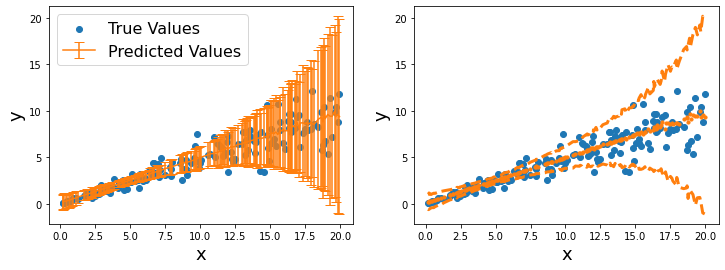

In [36]:
# Let's Plot The Predicted Means with The Errorbars as 
# 2sigma. 

fig, ax = plt.subplots(1,2,figsize=(12,4))
font_size = 18

ax[0].scatter(x_test.numpy(),y_test,label="True Values")
ax[0].errorbar(x_test.numpy(),mean_preds_all,yerr=2*std_preds_all,
               label="Predicted Values",c='C1',capsize=5)

ax[0].set_xlabel("x",fontsize=font_size)
ax[0].set_ylabel("y",fontsize=font_size)


ax[1].scatter(x_test.numpy(),y_test,label="True Values")
ax[1].scatter(x_test.numpy(),mean_preds_all,label="True Values",c='C1',s=10)
ax[1].plot(x_test.numpy(), mean_preds_all+2*std_preds_all, linestyle="--",c='C1',lw=3)
ax[1].plot(x_test.numpy(), mean_preds_all-2*std_preds_all, linestyle="--",c='C1',lw=3)

ax[0].legend(loc="best",fontsize=font_size-2)

ax[1].set_xlabel("x",fontsize=font_size)
ax[1].set_ylabel("y",fontsize=font_size)

**Discuss:**

1. How this plot different from the non-MCD plot? 
2. Is it apparent that we are averaging for multiple models here?
3. Do the unceretainties look callibrated? 

**That concludes our interaction with MCD. Now, let's go back to the slides**

**Note: If you are using MCD for your research, remember to TUNE your dropout rate (more on this in the slides)**

#Demo 4: HMC With hamiltorch

##4.1: Loading the Data

Let's move on to some new (more complicated) data! 

For this regression example, let's use the data from  Izmailov et al. (2019) The functions for loading the data in the next cell come from the git repo:

"Depth Uncertainty in Neural Networks" https://github.com/cambridge-mlg/DUN/blob/master/src/utils.py

In [37]:
!pip install git+https://github.com/AdamCobb/hamiltorch
import hamiltorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-2sytrzr4
  Running command git clone --filter=blob:none --quiet https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-2sytrzr4
  Resolved https://github.com/AdamCobb/hamiltorch to commit c6b243f3487532e2c1d34a666f613eecbb3c274a
  Preparing metadata (setup.py) ... done
  Created wheel for hamiltorch: filename=hamiltorch-0.4.0.dev2-py3-none-any.whl size=20543 sha256=748f7b309523fb38eb3ce033bdc8323a9e58bd6ef1b98602f3e89f57fd2f8502
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsy4lkzk/wheels/81/3f/f8/50fd124562118bff6d77852f4a4f1ad49929c6d390ff684b30
Successfully built hamiltorch


In [38]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def load_agw_1d(base_dir, get_feats=False):
    if not path.exists(base_dir + '/agw_data'):
        mkdir(base_dir + '/agw_data')
        urllib.urlretrieve('https://raw.githubusercontent.com/wjmaddox/drbayes/master/experiments/synthetic_regression/ckpts/data.npy',
                           filename=base_dir + '/agw_data/data.npy')

    def features(x):
        return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

    data = np.load(base_dir + '/agw_data/data.npy')
    x, y = data[:, 0], data[:, 1]
    y = y[:, None]
    f = features(x)

    x_means, x_stds = x.mean(axis=0), x.std(axis=0)
    y_means, y_stds = y.mean(axis=0), y.std(axis=0)
    f_means, f_stds = f.mean(axis=0), f.std(axis=0)

    X = ((x - x_means) / x_stds).astype(np.float32)
    Y = ((y - y_means) / y_stds).astype(np.float32)
    F = ((f - f_means) / f_stds).astype(np.float32)

    if get_feats:
        return F, Y

    return X[:, None], Y


#### Note the location the data will be stored!!!

folder = '../../../data/'

X, Y = load_agw_1d(folder, get_feats=False)
X = torch.Tensor(X).view(-1,1)
Y = torch.Tensor(Y).view(-1,1)

X_test = torch.linspace(-2,2,500).view(-1,1)

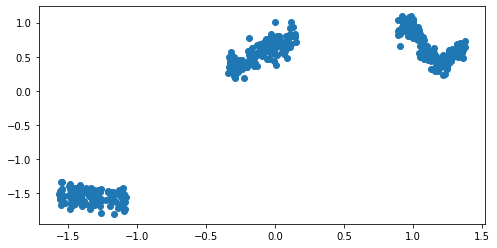

In [39]:
plt.figure(figsize=(8,4))
plt.scatter(X,Y)

# 4.2: Define a Model and Draw Samples

The following code is adapted from [this following notebook](https://github.com/AdamCobb/hamiltorch/blob/master/notebooks/hamiltorch_split_HMC_BNN_example.ipynb) 


In [40]:
## Using GPUs if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


## Defining a Model That We Want to Use
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [41]:
step_size = 0.0005
num_samples = 1000
L = 30
burn = -1
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = 1.0 # Prior Precision
tau_out = 110.4439498986428 # Output Precision
r = 0 # Random seed

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

In [42]:
print(params_init.shape)
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

## Now,let's sample the model
hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net, X.to(device), Y.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]


# Let's predict over the entire test range [-2,2]
pred_list, log_probs_f = hamiltorch.predict_model(net, x = X_test.to(device),
                                                  y = X_test.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
# Let's evaluate the performance over the training data
pred_list_tr, log_probs_split_tr = hamiltorch.predict_model(net, x = X.to(device), y=Y.to(device),
                                                            samples=params_hmc_gpu, model_loss=model_loss,
                                                            tau_out=tau_out, tau_list=tau_list)
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - Y) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - Y) ** 2).sum(0)

torch.Size([10401])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec

Acceptance Rate 0.56


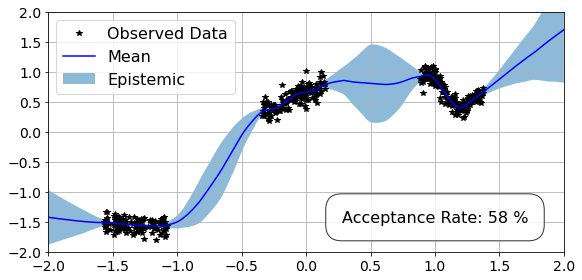

In [43]:
fs = 16

m = pred_list[200:].mean(0).to('cpu')
s = pred_list[200:].std(0).to('cpu')

f, ax = plt.subplots(1, 1, figsize=(8, 4))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()


# Plot training data as black stars
ax.plot(X.numpy(), Y.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(X_test.numpy(), m.numpy(), 'b', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(X_test.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)

ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Epistemic'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}
plt.text(1., -1.5, 'Acceptance Rate: 58 %', bbox=bbox, fontsize=16, horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

**Exercise for Later:** Note that the in the above implementation, I have not included aleatoric uncertainties. Alter the code above to include aleatoric uncertainties! 

# Demo 5: Applying what we learnt on a real astrophysics problem using GaMPEN!

For most of this demo, I will be using pre-defined functions in GaMPEN. The idea is to show you:-

1. How easy it is these days to incorporate uncertainties into your models
2. So that you can simply repurpose code from the [GaMPEN Github repo](https://github.com/aritraghsh09/GaMPEN) for your own problem! 

## Getting Images & Models to Perform Prediction

### Downloading Images and Creating the Necessary Folder Structure

Let's get some Hyper Suprime Cam images from its 2nd Public Data Release that we can use to perform predictions. For this demo, we will use the images from Fig. 13 of [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf)

**⚠ NOTE:** In order for GaMPEN to work, you need to point it to a `/data/` folder which has all the key components it needs (this folder doesn't necessarily need to be name).  In the data folder, at the very least, you should have 
  * a `/cutouts/` folder with all the images on which you want to perform analysis
  * an `info.csv` file with file names of the various images.

In [44]:
# Let's create two data-directories in our Colab runtime
# One containing low-z images and one containing mid-z images. 
%cd /content/
!mkdir data_lowz
!mkdir data_lowz/cutouts/
!mkdir data_midz
!mkdir data_midz/cutouts/

/content


In [45]:
#Now let's get some contents for these folders from the Yale FTP Servers

%cd /content/data_lowz/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/info.csv 

%cd /content/data_lowz/cutouts/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/cutouts/*.fits

%cd /content/data_midz/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_midz/info.csv 

%cd /content/data_midz/cutouts/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_midz/cutouts/*.fits

/content/data_lowz
--2023-01-30 17:21:44--  ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/info.csv
           => ‘info.csv’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz ... done.
==> SIZE info.csv ... 102
==> PASV ... done.    ==> RETR info.csv ... done.
Length: 102 (unauthoritative)

info.csv            100%[===================>]     102  --.-KB/s    in 0.02s   

2023-01-30 17:21:45 (4.63 KB/s) - ‘info.csv’ saved [102]

/content/data_lowz/cutouts
--2023-01-30 17:21:45--  ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/cutouts/*.fits
           => ‘.listing’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astr

### Downloading the Trained Models

Now, let's download the models we trained on Hyper Suprime Cam Imaging in [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf). Since our images are from the low redshift bin, we download the corresponding trained model. 

In [46]:
%cd /content/
%mkdir trained_models
%cd trained_models

!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/trained_model/g_0_025_real_data.pt

/content
/content/trained_models
--2023-01-30 17:22:26--  ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/trained_model/g_0_025_real_data.pt
           => ‘g_0_025_real_data.pt’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/hsc_morph/g_0_025/trained_model ... done.
==> SIZE g_0_025_real_data.pt ... 572517399
==> PASV ... done.    ==> RETR g_0_025_real_data.pt ... done.
Length: 572517399 (546M) (unauthoritative)

g_0_025_real_data.p 100%[===================>] 546.00M  59.6MB/s    in 9.7s    

2023-01-30 17:22:36 (56.3 MB/s) - ‘g_0_025_real_data.pt’ saved [572517399]



**⚠ NOTE:** Details about all the publicly-available GaMPEN models as well as the morphological catalogs for all galaxies in [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf) can be found in our [Public Data Release Handbook](https://gampen.readthedocs.io/en/latest/Public_data.html)

### Inspecting the Files


As outlined before, the only mandatory coulmn in the info.csv file is a column called `file_name` with the full name of each image file in the `/cutouts/` folder.


Now, let's take a quick look at the images. Note that HSC's cutout tool sometimes returns images with slightly different cutout-sizes (in terms of pixels). Thus, if you are using our models for performing inference, we recommend downloading cutouts that are at least 250x250 pixels. Then, using the correct options in GaMPEN, these will be cropped automatically while performing inference. 

Our pre-trained models accept the following sizes as input sizes for their images:-

* Low-z: $239 \times 239$ pixels
* Mid-z: $143 \times 143$ pixels
* High-z: $96 \times 96$ pixels

Inspite of the fact the GaMPEN automatically crops galaxies, we still start out with different sizes for each redshift bin as training & inference time goes down drastically with reduction in image size. Thus, it makes no senese to start with the same sizes for the low- and high-z bins. Each size above is chosen such that most galaxies at these redshifts will have $10 \times R_e < $ cutout size. 

In [47]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.1
    Uninstalling matplotlib-3.3.1:
      Successfully uninstalled matplotlib-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.6.0 which is incompatible.
fastai 2.7.10 requires torchvision>=0.8.2, but you have torchvision 0.7.0 which is incompatible.


In [48]:
import pylab as plt
import matplotlib as mpl
from astropy.io import fits

LOGMIN = 1e-3

#Defining a function to crop images
def crop_center(img, cropx, cropy):
    
    #Function from 
    #https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    
    y, x, *_ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty + cropy, startx:startx + cropx, ...]

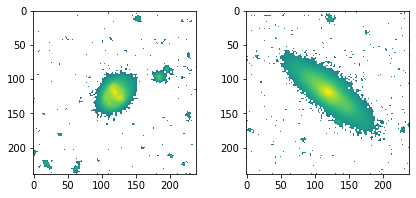

In [49]:
#Low-z Data
fig, ax = plt.subplots(1,2,figsize=(7,3))

for i,img_num in enumerate([45849776612206843, 71112151477012948]):
  img_data = fits.getdata('/content/data_lowz/cutouts/' + str(img_num) + '.fits')

  #Now, let's crop the image to it's starting size
  img_data = crop_center(img_data, 239, 239)

  ax[i].imshow(img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))

## Running the Inference module

Now using the downloaded models and images, let's perform inference.

### Low-z

First, let's use the lowz model to perform inference on the lowz images.

For performing inference, first we need to create a directory to store the output files. Let's call this directory `bayesian_inference_runs`.

Additionally since we will be using models that have already been trained, we will be making predictions for the following three variables:-

$$ \left( \log\frac{L_B/L_T}{1-L_B/L_T}, \log R_e, \log \mathrm{Flux} \right) $$

The variables were additionally standard-scaled (i.e., mean subtracted and variance set to 1) during training (for more details see Section 4.1 of [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf)). Now, in order to perform the inverse scaling properly, we need access to the different training values of these variables that were used to perform the forward scaling.

We make a separate directory called `scaling_data_lowz` and `scaling_data_midz` to place the relevant `info.csv` and `/splits/` files from the Yale FTP Servers. These were the files used for training and will help us unscale the predicted values back to ($L_B/L_T$,$R_e$, Flux). You should use the same options for these options if you are using our pre-trained models (as well as the corresponding options for the mid and high-z models)

In [50]:
%cd /content/
%mkdir bayesian_inference_runs_lowz
%mkdir scaling_data_dir_lowz
%mkdir scaling_data_dir_lowz/splits/

%cd /content/scaling_data_dir_lowz/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/scaling_data_dir/info.csv

%cd /content/scaling_data_dir_lowz/splits/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/scaling_data_dir/splits/*.csv

/content
/content/scaling_data_dir_lowz
--2023-01-30 17:24:54--  ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/scaling_data_dir/info.csv
           => ‘info.csv’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/hsc_morph/g_0_025/scaling_data_dir ... done.
==> SIZE info.csv ... 7682214
==> PASV ... done.    ==> RETR info.csv ... done.
Length: 7682214 (7.3M) (unauthoritative)

info.csv            100%[===================>]   7.33M  14.8MB/s    in 0.5s    

2023-01-30 17:24:56 (14.8 MB/s) - ‘info.csv’ saved [7682214]

/content/scaling_data_dir_lowz/splits
--2023-01-30 17:24:56--  ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/scaling_data_dir/splits/*.csv
           => ‘.listing’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.

The backbone of performing inference is the `inference.py` file at `/GaMPEN/ggt/modules/`.

In order to use this file, we run it by passing different variables to the inferece file. In order to understand the various options that can be specified while running inference you can type `!python GaMPEN/ggt/modules/inference.py --help` in a Google Colab code cell or consult the documentation [here](https://gampen.readthedocs.io/en/latest/Using_GaMPEN.html#inference). 


Since the data we are using for inference doesn't have any ground-truth data available, we set `split` and `slug` to `None` and pass the `--no-labels` option to specify that we don't have any labels available for these images. 

In order to unscale the predictions back, we specify the path to the appropriate `scaling_data_dir` that we created in the previous step. We specify the `scaling_slug` as `balanced-dev2` since this was the option that was used for the pre-trained model and the scaling file we are using is named `balanced-dev2-train.csv`. All that is done using this file is that the full range of values for the prediction columns specified are read in --> their mean and standard deviation is determined --> and this is then used for unscaling the predicted values. If you are using your own trained models, you should of course point this to the relevant file in `/splits/` in your trainin data directory. 

**The `--mc-dropout` and `--cov-errors` options specify that we want to perform both Monte Carlo dropout during inference as well include aleatoric errors in each of the Monte Carlo runs.**The `n_runs` parameter controls the number of different Monte Carlo models generated for prediction. For a robust analysis, we recommend setting this to `500` or `1000`. We set this to `50` here just for demonstrative purposes. 



In [51]:
%cd /content/

!python GaMPEN/ggt/modules/inference.py\
  --model_path='trained_models/g_0_025_real_data.pt'\
  --output_path="bayesian_inference_runs_lowz/"\
  --data_dir='data_lowz/'\
  --split=None\
  --slug=None\
  --cutout_size=239\
  --normalize\
  --transform\
  --n_workers=2\
  --parallel\
  --label_cols='custom_logit_bt,ln_R_e_asec,ln_total_flux_adus'\
  --model_type='vgg16_w_stn_oc_drp'\
  --repeat_dims\
  --channels=3\
  --label_scaling='std'\
  --mc_dropout\
  --cov_errors\
  --dropout_rate=0.0004\
  --n_runs=50\
  --no-labels\
  --scaling_data_dir='scaling_data_dir_lowz/'\
  --scaling_slug='balanced-dev2'


/content
[2023-01-30 17:25:33,755] Performing pure inference without labels. Using
            column names to infer number of expected outputs.
            Split and Slug values entered will be ignored and
            info.csv will be used.
[2023-01-30 17:25:33,756] Loading images to device...
[2023-01-30 17:25:33,764] Generating PyTorch tensors from FITS files...
100% 2/2 [00:00<00:00, 146.60it/s]
[2023-01-30 17:25:33,780] Preloading 2 tensors...
100% 2/2 [00:00<00:00, 403.74it/s]
[2023-01-30 17:25:33,818] Running inference run 1
[2023-01-30 17:25:33,839] No GPU found; falling back to CPU
[2023-01-30 17:25:33,839] Using dropout rate of 0.0004 in the model
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:04<00:00, 132MB/s]
[2023-01-30 17:25:41,484] Loading model...
[2023-01-30 17:25:42,000] Performing predictions...
[2023-01-30 17:25:42,001] Activating Monte Carlo dropout...
100% 1/1 [00:0

Note that output `.csv` files are stored in the output directory we specified. As many `.csv` files are created as the number of runs specified in `n_runs` and are named `inf_xx.csv`. Each file corresponds to the values predicted using a different model created using Monte Carlo Dropout. Each file will contain one sampled value from the predicted distribution by that model.

Let's take a look at `inf_1.csv`

In [ ]:
import pandas as pd

inf_1 = pd.read_csv('/content/bayesian_inference_runs_lowz/inf_1.csv')
inf_1

,object_id,file_name,preds_custom_logit_bt,preds_ln_R_e_asec,preds_ln_total_flux_adus
0,45849776612206843,45849776612206843.fits,-1.116584,0.615151,8.055857
1,71112151477012948,71112151477012948.fits,1.144712,1.037505,9.459242


As expected we have the predicted values for each columns specified during inference. Note that these have already been un-scaled in terms of the the minmax/standard scaling specified. However, they are still in the format 

$$ \left( \log\frac{L_B/L_T}{1-L_B/L_T}, \log R_e, \log \mathrm{Flux} \right) $$


Now, we will use the [`result_aggregator.py`](https://github.com/aritraghsh09/GaMPEN/blob/master/ggt/modules/result_aggregator.py) file in GaMPEN to collate all these .csvs. The `result_aggregator` module of GaMPEN will collect all the csvs; scale the values back to $L_B/L_T$, $R_e$, Flux; produce summary statistics; as well as produce PDFs of the output variables for each image. 

**For an understanding of all the options available in the `result_aggregator` module, please refere to [this page.](https://gampen.readthedocs.io/en/latest/Using_GaMPEN.html#result-aggregator)**

The `data_dir` must point to the directory with the output csvs and the `out_summary_df_path` to the location you want the summary data-frame to be stored. 

The `unscale` option here specifies that we want to perform the inverse logit and logarithmic scalings. The `scaling_data_dir` should again point to the scaling files used during training (see previous discussion).

In [ ]:
%cd /content/
%mkdir lowz_pdfs

!python /content/GaMPEN/ggt/modules/result_aggregator.py\
    --data_dir="bayesian_inference_runs_lowz/"\
    --num=50\
    --out_summary_df_path="bayesian_inference_runs_lowz/summary.csv"\
    --out_pdfs_path="lowz_pdfs/"\
    --unscale\
    --scaling_df_path="scaling_data_dir_lowz/info.csv"\
    --drop_old

/content
Loading Files.....
100% 50/50 [00:09<00:00,  5.21it/s]
Creating Data Array
100% 50/50 [00:00<00:00, 329.33it/s]
Calculating Conf Ints for preds_R_e_asec
100% 2/2 [00:00<00:00, 18.73it/s]
Calculating Conf Ints for preds_total_flux_adus
100% 2/2 [00:00<00:00, 35.21it/s]
Calculating Conf Ints for preds_bt
100% 2/2 [00:00<00:00, 37.21it/s]
Calculating Conf Ints for preds_total_mag
100% 2/2 [00:00<00:00, 34.40it/s]
Saving PDFs as Arrays
100% 2/2 [00:00<00:00, 136.38it/s]


Now, let's inspect the `summary.csv` file as well as the predicted PDFs. 


In [ ]:
import pandas as pd

summary_lowz = pd.read_csv('/content/bayesian_inference_runs_lowz/summary.csv')
summary_lowz

,object_id,file_name,preds_R_e_asec_mean,preds_R_e_asec_median,preds_R_e_asec_std,preds_R_e_asec_skew,preds_R_e_asec_kurtosis,preds_R_e_asec_mode,preds_R_e_asec_sig_ci,preds_R_e_asec_twosig_ci,...,preds_bt_threesig_ci,preds_total_mag_mean,preds_total_mag_median,preds_total_mag_std,preds_total_mag_skew,preds_total_mag_kurtosis,preds_total_mag_mode,preds_total_mag_sig_ci,preds_total_mag_twosig_ci,preds_total_mag_threesig_ci
0,45849776612206843,45849776612206843.fits,1.820383,1.817087,0.033035,0.088111,0.364540,1.819898,"(1.7849062023871562, 1.8548905780783351)","(1.7437085033965363, 1.896088277068955)",...,"(0.017120892971267457, 0.6071860425100599)",18.330711,18.317148,0.078251,0.518924,0.128911,18.291817,"(18.203980020792837, 18.379654918407713)","(18.160436670101973, 18.494519274540515)","(18.160436670101973, 18.535435009241414)"
1,71112151477012948,71112151477012948.fits,2.651862,2.660352,0.099627,-0.231496,-0.112394,2.655467,"(2.5474644276399103, 2.7634696637768608)","(2.446881836766979, 2.8417921730631597)",...,"(0.24711985189174737, 0.7585437171245606)",16.795830,16.803533,0.093847,-0.397087,-0.410068,16.847730,"(16.73570179486509, 16.959757791182813)","(16.60634116302882, 16.989350092583265)","(16.5670256768825, 16.989350092583265)"


In [ ]:
print(summary_lowz.columns)

Index(['object_id', 'file_name', 'preds_R_e_asec_mean',
       'preds_R_e_asec_median', 'preds_R_e_asec_std', 'preds_R_e_asec_skew',
       'preds_R_e_asec_kurtosis', 'preds_R_e_asec_mode',
       'preds_R_e_asec_sig_ci', 'preds_R_e_asec_twosig_ci',
       'preds_R_e_asec_threesig_ci', 'preds_total_flux_adus_mean',
       'preds_total_flux_adus_median', 'preds_total_flux_adus_std',
       'preds_total_flux_adus_skew', 'preds_total_flux_adus_kurtosis',
       'preds_total_flux_adus_mode', 'preds_total_flux_adus_sig_ci',
       'preds_total_flux_adus_twosig_ci', 'preds_total_flux_adus_threesig_ci',
       'preds_bt_mean', 'preds_bt_median', 'preds_bt_std', 'preds_bt_skew',
       'preds_bt_kurtosis', 'preds_bt_mode', 'preds_bt_sig_ci',
       'preds_bt_twosig_ci', 'preds_bt_threesig_ci', 'preds_total_mag_mean',
       'preds_total_mag_median', 'preds_total_mag_std', 'preds_total_mag_skew',
       'preds_total_mag_kurtosis', 'preds_total_mag_mode',
       'preds_total_mag_sig_ci', 'preds_

As can be seen in the summary file, for every prediction column we have the 

  * mean (_mean)
  * median (_median)
  * mode (_mode)
  * standard deviation (_std)
  * skewness (_skew)
  * kurtosis (_kurt)
  * $1\sigma$ confidence interval (_sig_ci)
  * $2\sigma$ confidence interval (_twosig_ci)
  * $3\sigma$ confidence interval (_threesig_ci)

for the predicted distribution. 

**⚠ STOP: Note that the `result_aggregator` module also converts flux to magnitudes; however this coversion assumes a photometric zeropoint that is only true for HSC. If you are using the `result_aggregator` module for some other survey, you should change this.**


## Plotting Results

Now, let's make a plot for the predicted distributions against the images.

### Importing required packages & Defining Functions

In [ ]:
!pip install matplotlib==3.1.3

import matplotlib as mpl
import numpy as np
import pylab as plt
import pandas as pd


import random
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from astropy.io import fits 
LOGMIN=1e-4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def plot_hists(summary_file_path,
               imgdir, pdf_dir,
               font_size=15,
               cutout_size=239):
  
  summary_df = pd.read_csv(summary_file_path)

  fig,ax1 = plt.subplots(len(summary_df),4,figsize=(4*5.3,len(summary_df)*4),
                          gridspec_kw={'width_ratios': [0.65, 1, 1, 1]})
  fig.subplots_adjust(wspace=0.12,hspace=0.23)

  row_counter = 0

  for i, img_num in enumerate(summary_df["object_id"]):
        
    ax = ax1[row_counter]
    ax[0].set_xticks([])
    ax[0].set_yticks([])
        
    img_data = fits.getdata(imgdir
                            + str(img_num) + ".fits")
    img_data = crop_center(img_data,cutout_size,cutout_size)
    ax[0].imshow(img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))

    pred_arr = np.load(pdf_dir + str(img_num) + ".npy")
  
    pred_cols = ["preds_bt","preds_R_e_asec","preds_total_mag"]
    pred_arr_idxs = [2,0,3] #indexes of columns in pred_arr

    for j, column_name in enumerate(pred_cols):

      ax[j+1].plot(pred_arr[pred_arr_idxs[j]],
                   pred_arr[pred_arr_idxs[j]+4],
                   label="PDF",lw=3)
      

      mode = summary_df[column_name + "_mode"][i]
      sig_ci = summary_df[column_name + "_sig_ci"][i]
      sig_ci = (float(sig_ci.split(',')[0][1:]),
                float(sig_ci.split(',')[1][:-1]))
      twosig_ci = summary_df[column_name + "_twosig_ci"][i]
      twosig_ci = (float(twosig_ci.split(',')[0][1:]),
                   float(twosig_ci.split(',')[1][:-1]))
      threesig_ci = summary_df[column_name + "_threesig_ci"][i]
      threesig_ci = (float(threesig_ci.split(',')[0][1:]),
                     float(threesig_ci.split(',')[1][:-1]))
      n_out = pred_arr[pred_arr_idxs[j]+4]
      
      ax[j+1].plot([mode,mode],[0,np.max(pred_arr[pred_arr_idxs[j]+4])],c='r',
                      ls='solid',label="Mode", lw =3) #plotting a x = Mode line
            
            
            
      rect = Rectangle((sig_ci[0], 0), sig_ci[1]-sig_ci[0], 0.25*np.max(n_out),color='coral',
                             alpha=0.5,label="68.27 %ile",lw=1)
      border = Rectangle((sig_ci[0], 0), sig_ci[1]-sig_ci[0], 0.25*np.max(n_out),ec='coral',
                             lw=3,fill=False)
      ax[j+1].add_patch(rect)  
      ax[j+1].add_patch(border)
    
      rect = Rectangle((twosig_ci[0], 0), twosig_ci[1]-twosig_ci[0], 0.175*np.max(n_out),color='goldenrod',
                             alpha=0.5,label="95.45 %ile")
      border = Rectangle((twosig_ci[0], 0), twosig_ci[1]-twosig_ci[0], 0.175*np.max(n_out),ec='goldenrod',
                             lw=3,fill=False)
      ax[j+1].add_patch(rect)
      ax[j+1].add_patch(border)
    
      rect = Rectangle((threesig_ci[0], 0), threesig_ci[1]-threesig_ci[0], 0.10*np.max(n_out),
                             color='seagreen',alpha=0.5,label="99.73 %ile")
      border = Rectangle((threesig_ci[0], 0), threesig_ci[1]-threesig_ci[0], 0.10*np.max(n_out),ec='seagreen',
                             lw=3,fill=False)
      ax[j+1].add_patch(rect)
      ax[j+1].add_patch(border)
            
            
            
      #ax[j+1].ticklabel_format(axis='both',style='sci',scilimits=(0,0))
      ax[j+1].set_yticks([])
      ax[j+1].tick_params(axis='x',labelsize=font_size-3)
            
                
    if row_counter == 0:
            ax[1].legend(loc='upper right',prop={'size': font_size-4})
            
                
              
    row_counter += 1


  ax[1].set_xlabel(r"$L_B/L_T$",fontsize=font_size)
  ax[2].set_xlabel(r"$R_e$ (asec)",fontsize=font_size)
  ax[3].set_xlabel(r"mag (g-band)",fontsize=font_size)



### Making Plots

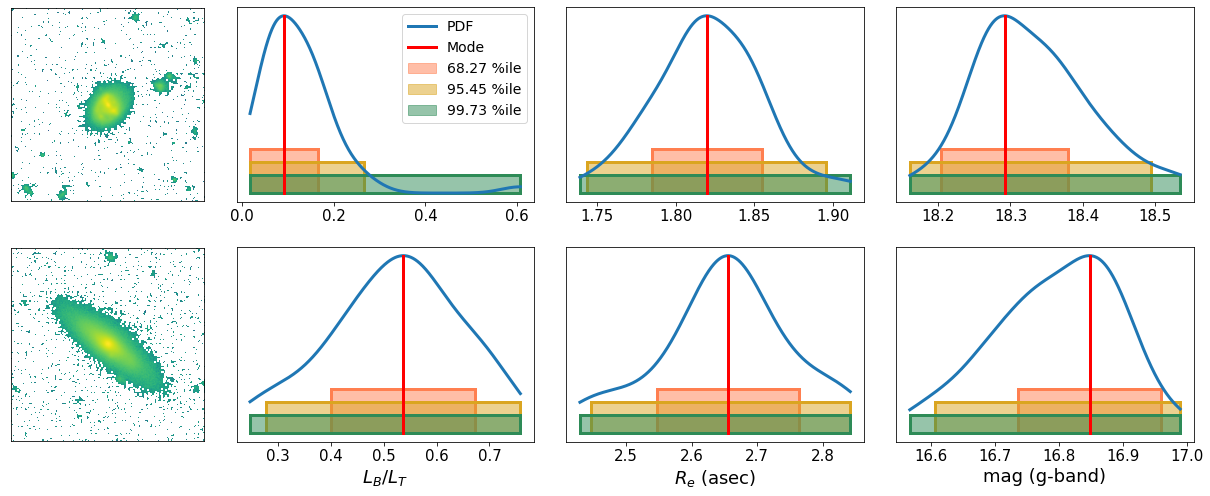

In [ ]:
plot_hists(imgdir="/content/data_lowz/cutouts/",
           summary_file_path="/content/bayesian_inference_runs_lowz/summary.csv",
           pdf_dir="/content/lowz_pdfs/",
           font_size=18)

**NOTE: Some of the distributions above are multimodal and look a bit funky. This is primarily because we ran inference with 50 runs. For better results, re-run inference with 500/1000 runs!**